https://github.com/h2oai/h2o-tutorials/blob/master/h2o-world-2017/automl/Python/automl_binary_classification_product_backorders.ipynb
    
# H2O AutoML Binary Classification Demo

This is a Jupyter Notebook. When you execute code within the notebook, the results appear beneath the code. To execute a code chunk, place your cursor on the cell and press Shift+Enter.

## Start H2O

Import the `h2o` Python module and `H2OAutoML` class and initialize a local H2O cluster.

In [1]:
import h2o
from h2o.automl import H2OAutoML

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_362"; OpenJDK Runtime Environment (build 1.8.0_362-b08); OpenJDK 64-Bit Server VM (build 25.362-b08, mixed mode)
  Starting server from /home/stever7/.local/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjwlyqx7u
  JVM stdout: /tmp/tmpjwlyqx7u/h2o_stever7_started_from_python.out
  JVM stderr: /tmp/tmpjwlyqx7u/h2o_stever7_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,"1 year, 2 months and 29 days !!!"
H2O_cluster_name:,H2O_from_python_stever7_krc30t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,26.63 Gb
H2O_cluster_total_cores:,64
H2O_cluster_allowed_cores:,64
H2O_cluster_status:,"locked, healthy"


## Load Data

For the AutoML binary classification demo, we use a subset of the Product Backorders dataset: 

https://www.kaggle.com/tiredgeek/predict-bo-trial/data

The goal here is to predict whether or not a product will be put on backorder status, given a number of product metrics such as current inventory, transit time, demand forecasts and prior sales.

In [3]:
# Use local data file or download from GitHub

import os

docker_data_path = "/home/h2o/data/automl/product_backorders.csv"

if os.path.isfile(docker_data_path):
  data_path = docker_data_path
else:
  data_path = "https://github.com/h2oai/h2o-tutorials/raw/master/h2o-world-2017/automl/data/product_backorders.csv"

In [4]:
# Load data into H2O
df = h2o.import_file(data_path)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


For classification, the response should be encoded as categorical (aka. "factor" or "enum"). Let's take a look.

In [5]:
df.describe()

Rows:19053
Cols:23




,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
type,int,int,int,int,int,int,int,int,int,int,int,int,enum,int,real,real,int,enum,enum,enum,enum,enum,enum
mins,1111620.0,-1440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,-99.0,-99.0,0.0,,,,,,
mean,2059552.760562641,376.36702881435997,7.706036161335188,48.272345562378625,182.91082769117725,344.73983099774307,497.79242114102766,56.11887891670603,168.5344565160342,333.53219965359784,504.25539285151933,48.84070750013121,,2.311499501390857,-6.519833622001784,-6.05393533826694,0.8917755734005144,,,,,,
maxs,3284775.0,730722.0,52.0,170920.0,479808.0,967776.0,1418208.0,186451.0,550609.0,1136154.0,1759152.0,85584.0,,13824.0,1.0,1.0,1440.0,,,,,,
sigma,663337.6456498678,7002.071628662687,6.7786650721241895,1465.999210206829,4304.865591970628,8406.062155159243,12180.570042918358,1544.2177775482564,4581.340080221506,9294.566153218982,14184.145395653624,968.7738680675266,,110.24106014611986,25.975138766871876,25.18449715003253,23.033345417338797,,,,,,
zeros,0,1858,121,15432,12118,11136,10604,10278,8022,6864,6231,9909,,18601,474,401,18585,,,,,,
missing,0,0,1078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1113121.0,0.0,8.0,1.0,6.0,6.0,6.0,0.0,4.0,9.0,12.0,0.0,No,1.0,0.9,0.89,0.0,No,No,No,Yes,No,Yes
1,1113268.0,0.0,8.0,0.0,2.0,3.0,4.0,1.0,2.0,3.0,3.0,0.0,No,0.0,0.96,0.97,0.0,No,No,No,Yes,No,Yes
2,1113874.0,20.0,2.0,0.0,45.0,99.0,153.0,16.0,42.0,80.0,111.0,10.0,No,0.0,0.81,0.88,0.0,No,No,No,Yes,No,Yes


We will notice that the response column, `"went_on_backorder"`, is already encoded as "enum", so there's nothing we need to do here. If it were encoded as a 0/1 "int", then we'd have to convert the column as follows: 

```
df[y] = df[y].asfactor()
```

Next, let's identify the response and predictor columns by saving them as `x` and `y`. The `"sku"` column is a unique identifier so we'll want to remove that from the set of our predictors.

In [6]:
y = "went_on_backorder"
x = df.columns
x.remove(y)
x.remove("sku")

## Run AutoML

Run AutoML, stopping after 10 models. The `max_models` argument specifies the number of individual (or "base") models, and does not include the two ensemble models that are trained at the end.

In [7]:
aml = H2OAutoML(max_models=10, seed=1)
aml.train(x=x, y=y, training_frame=df)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_2_AutoML_1_20230516_144637

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.03097148348640562
RMSE: 0.17598716852772425
LogLoss: 0.11079814450057998
Null degrees of freedom: 10047
Residual degrees of freedom: 10039
Null deviance: 7374.795081759208
Residual deviance: 2226.5995118836554
AIC: 2244.5995118836554
AUC: 0.9832933087709308
AUCPR: 0.9153846924589029
Gini: 0.9665866175418616

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4489343354104793: 


,,No,Yes,Error,Rate
0,No,8687.0,155.0,0.0175,(155.0/8842.0)
1,Yes,237.0,969.0,0.1965,(237.0/1206.0)
2,Total,8924.0,1124.0,0.039,(392.0/10048.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.448934,0.831760,168.0
1,max f2,0.184645,0.860625,254.0
2,max f0point5,0.559863,0.871678,136.0
3,max accuracy,0.518455,0.961087,147.0
4,max precision,0.992345,1.000000,0.0
5,max recall,0.004086,1.000000,388.0
6,max specificity,0.992345,1.000000,0.0
7,max absolute_mcc,0.448934,0.810368,168.0
8,max min_per_class_accuracy,0.188597,0.932481,252.0
9,max mean_per_class_accuracy,0.157812,0.935691,267.0



Gains/Lift Table: Avg response rate: 12.00 %, avg score: 12.18 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010052,0.952543,8.331675,8.331675,1.000000,0.968387,1.000000,0.968387,0.083748,0.083748,733.167496,733.167496,0.083748
1,2,0.020004,0.924404,8.331675,8.331675,1.000000,0.938104,1.000000,0.953321,0.082919,0.166667,733.167496,733.167496,0.166667
2,3,0.030056,0.898838,8.249183,8.304087,0.990099,0.912033,0.996689,0.939513,0.082919,0.249585,724.918313,730.408663,0.249472
3,4,0.040008,0.866620,8.331675,8.310949,1.000000,0.882842,0.997512,0.925415,0.082919,0.332504,733.167496,731.094940,0.332391
4,5,0.050060,0.825395,8.001708,8.248855,0.960396,0.846546,0.990060,0.909579,0.080431,0.412935,700.170763,724.885513,0.412370
5,6,0.100020,0.526157,6.771561,7.510943,0.812749,0.685489,0.901493,0.797646,0.338308,0.751244,577.156052,651.094280,0.740047
6,7,0.150080,0.265646,2.898694,5.972507,0.347913,0.382853,0.716844,0.659290,0.145108,0.896352,189.869407,497.250705,0.848059
7,8,0.200040,0.125508,1.294563,4.804185,0.155378,0.185555,0.576617,0.540974,0.064677,0.961028,29.456304,380.418471,0.864783
8,9,0.300060,0.040366,0.298448,3.302272,0.035821,0.071735,0.396352,0.384561,0.029851,0.990879,-70.155194,230.227250,0.785043
9,10,0.399980,0.018730,0.082985,2.498051,0.009960,0.027384,0.299826,0.295333,0.008292,0.999171,-91.701519,149.805134,0.680917




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.04986141819777073
RMSE: 0.2232967044041867
LogLoss: 0.16851530957102018
Null degrees of freedom: 19052
Residual degrees of freedom: 19045
Null deviance: 13901.345057634844
Residual deviance: 6421.44438651331
AIC: 6437.44438651331
AUC: 0.9518747064552273
AUCPR: 0.7521982063914671
Gini: 0.9037494129104546

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3576163957857999: 


,,No,Yes,Error,Rate
0,No,16017.0,770.0,0.0459,(770.0/16787.0)
1,Yes,596.0,1670.0,0.263,(596.0/2266.0)
2,Total,16613.0,2440.0,0.0717,(1366.0/19053.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.357616,0.709732,198.0
1,max f2,0.141452,0.779748,278.0
2,max f0point5,0.587133,0.737230,129.0
3,max accuracy,0.525077,0.932662,146.0
4,max precision,0.982298,1.000000,0.0
5,max recall,0.000356,1.000000,399.0
6,max specificity,0.982298,1.000000,0.0
7,max absolute_mcc,0.407997,0.669723,181.0
8,max min_per_class_accuracy,0.128705,0.888791,284.0
9,max mean_per_class_accuracy,0.101517,0.891015,299.0



Gains/Lift Table: Avg response rate: 11.89 %, avg score: 11.89 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010025,9.310959e-01,7.527768,7.527768,0.895288,0.952280,0.895288,0.952280,0.075463,0.075463,652.776764,652.776764,0.074272
1,2,0.020049,8.965254e-01,7.439724,7.483746,0.884817,0.913610,0.890052,0.932945,0.074581,0.150044,643.972357,648.374560,0.147542
2,3,0.030022,8.625843e-01,7.346119,7.438030,0.873684,0.879388,0.884615,0.915155,0.073257,0.223301,634.611883,643.803042,0.219369
3,4,0.040046,8.220495e-01,7.131569,7.361315,0.848168,0.843614,0.875491,0.897246,0.071492,0.294793,613.156934,636.131473,0.289133
4,5,0.050018,7.761968e-01,6.947835,7.278879,0.826316,0.800765,0.865687,0.878011,0.069285,0.364078,594.783528,627.887917,0.356453
5,6,0.100037,5.005465e-01,5.426074,6.352476,0.645331,0.644452,0.755509,0.761231,0.271403,0.635481,442.607356,535.247636,0.607721
6,7,0.150003,2.663714e-01,3.197239,5.301467,0.380252,0.371692,0.630511,0.631476,0.159753,0.795234,219.723887,430.146653,0.732328
7,8,0.200021,1.336486e-01,1.773400,4.419218,0.210913,0.191998,0.525584,0.521578,0.088703,0.883936,77.339965,341.921837,0.776234
8,9,0.300005,4.340499e-02,0.648822,3.162640,0.077165,0.076804,0.376137,0.373346,0.064872,0.948808,-35.117763,216.263958,0.736382
9,10,0.399990,2.063023e-02,0.242757,2.432765,0.028871,0.030031,0.289332,0.287528,0.024272,0.973080,-75.724333,143.276464,0.650450


*Note: If you see the following error, it means that you need to install the pandas module.*

```
H2OTypeError: Argument `python_obj` should be a None | list | tuple | dict | numpy.ndarray | pandas.DataFrame | scipy.sparse.issparse, got H2OTwoDimTable 
```

## Leaderboard

Next, we will view the AutoML Leaderboard. Since we did not specify a `leaderboard_frame` in the `H2OAutoML.train()` method for scoring and ranking the models, the AutoML leaderboard uses cross-validation metrics to rank the models.

A default performance metric for each machine learning task (binary classification, multiclass classification, regression) is specified internally and the leaderboard will be sorted by that metric. In the case of binary classification, the default ranking metric is Area Under the ROC Curve (AUC). In the future, the user will be able to specify any of the H2O metrics so that different metrics can be used to generate rankings on the leaderboard.

The leader model is stored at `aml.leader` and the leaderboard is stored at `aml.leaderboard`.

In [8]:
lb = aml.leaderboard

Now we will view a snapshot of the top models. Here we should see the two Stacked Ensembles at or near the top of the leaderboard. Stacked Ensembles can almost always outperform a single model.

In [9]:
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_2_AutoML_1_20230516_144637,0.951875,0.168515,0.752198,0.154444,0.223297,0.0498614
StackedEnsemble_AllModels_5_AutoML_1_20230516_144637,0.951784,0.168695,0.751926,0.155046,0.223387,0.0499016
StackedEnsemble_BestOfFamily_3_AutoML_1_20230516_144637,0.951759,0.168899,0.751959,0.153113,0.223442,0.0499262
StackedEnsemble_BestOfFamily_2_AutoML_1_20230516_144637,0.951351,0.169659,0.74926,0.158555,0.224003,0.0501773
StackedEnsemble_BestOfFamily_6_AutoML_1_20230516_144637,0.951215,0.169459,0.749805,0.161316,0.223739,0.0500589
StackedEnsemble_AllModels_1_AutoML_1_20230516_144637,0.951146,0.16959,0.749583,0.156424,0.224023,0.0501862
StackedEnsemble_BestOfFamily_5_AutoML_1_20230516_144637,0.950136,0.170448,0.744467,0.149462,0.224544,0.0504198
StackedEnsemble_AllModels_4_AutoML_1_20230516_144637,0.950104,0.170762,0.743876,0.159872,0.224988,0.0506195
StackedEnsemble_BestOfFamily_1_AutoML_1_20230516_144637,0.948265,0.173242,0.739868,0.154965,0.226638,0.0513648
GBM_4_AutoML_1_20230516_144637,0.947608,0.17478,0.737148,0.163658,0.227059,0.0515557


To view the entire leaderboard, specify the `rows` argument of the `head()` method as the total number of rows:

In [10]:
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_2_AutoML_1_20230516_144637,0.951875,0.168515,0.752198,0.154444,0.223297,0.0498614
StackedEnsemble_AllModels_5_AutoML_1_20230516_144637,0.951784,0.168695,0.751926,0.155046,0.223387,0.0499016
StackedEnsemble_BestOfFamily_3_AutoML_1_20230516_144637,0.951759,0.168899,0.751959,0.153113,0.223442,0.0499262
StackedEnsemble_BestOfFamily_2_AutoML_1_20230516_144637,0.951351,0.169659,0.74926,0.158555,0.224003,0.0501773
StackedEnsemble_BestOfFamily_6_AutoML_1_20230516_144637,0.951215,0.169459,0.749805,0.161316,0.223739,0.0500589
StackedEnsemble_AllModels_1_AutoML_1_20230516_144637,0.951146,0.16959,0.749583,0.156424,0.224023,0.0501862
StackedEnsemble_BestOfFamily_5_AutoML_1_20230516_144637,0.950136,0.170448,0.744467,0.149462,0.224544,0.0504198
StackedEnsemble_AllModels_4_AutoML_1_20230516_144637,0.950104,0.170762,0.743876,0.159872,0.224988,0.0506195
StackedEnsemble_BestOfFamily_1_AutoML_1_20230516_144637,0.948265,0.173242,0.739868,0.154965,0.226638,0.0513648
GBM_4_AutoML_1_20230516_144637,0.947608,0.17478,0.737148,0.163658,0.227059,0.0515557


## Ensemble Exploration

To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model. The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run. This is often the top performing model on the leaderboard.

In [11]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:, 0])

# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])

# Get the Stacked Ensemble metalearner model
metalearner = se.metalearner()

Examine the variable importance of the metalearner (combiner) algorithm in the ensemble. This shows us how much each base learner is contributing to the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM.

In [12]:
metalearner.coef_norm()

{'Intercept': -3.789713560811744,
 'GBM_4_AutoML_1_20230516_144637': 0.5220457399977181,
 'XGBoost_3_AutoML_1_20230516_144637': 0.586644809682851,
 'GBM_1_AutoML_1_20230516_144637': 0.25156131625397504,
 'GBM_3_AutoML_1_20230516_144637': 0.0,
 'GBM_2_AutoML_1_20230516_144637': 0.0,
 'XGBoost_2_AutoML_1_20230516_144637': 0.3980974309198202,
 'XGBoost_1_AutoML_1_20230516_144637': 0.060469769246236274,
 'XRT_1_AutoML_1_20230516_144637': 0.4510262380160032,
 'DRF_1_AutoML_1_20230516_144637': 0.29831566783157726,
 'GLM_1_AutoML_1_20230516_144637': 0.025304500740685597}

We can also plot the base learner contributions to the ensemble.

AttributeError: 'Line2D' object has no attribute '_legmarker'

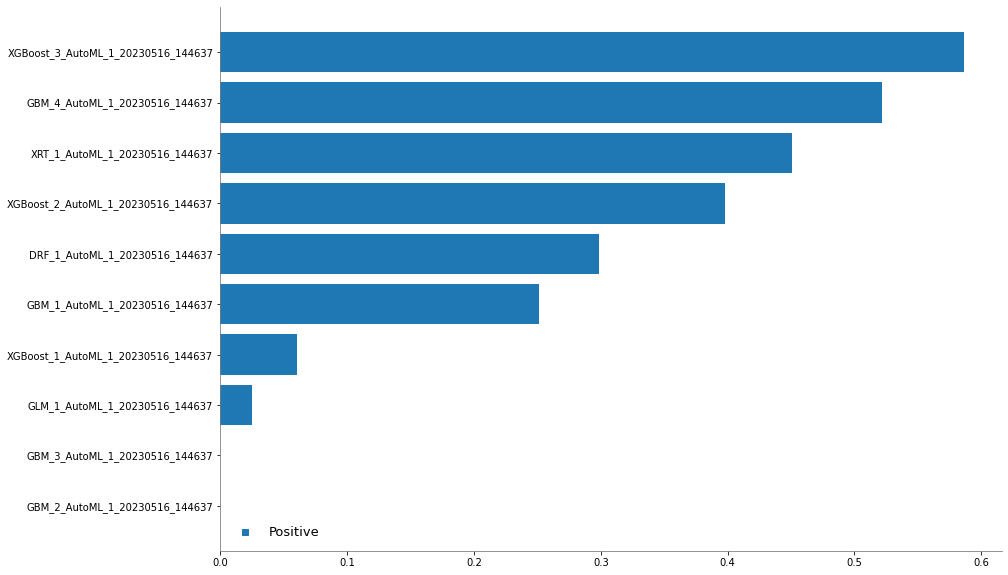

In [13]:
# %matplotlib inline

metalearner.std_coef_plot()

## Save Leader Model

There are two ways to save the leader model: binary format and MOJO format. If you're taking your leader model to production, then we'd suggest the MOJO format since it's optimized for production use.

In [ ]:
h2o.save_model(aml.leader, path = "./product_backorders_model_bin")

In [ ]:
aml.leader.download_mojo(path = "./")